In [1]:
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
SNAPSHOT_PATH = '/home/chengzhang/Multimodal-Quantization/MiniGPT-4/snapshot'
names = glob.glob(f'{SNAPSHOT_PATH}/weights/*/*.pt')
names = ['/'.join(name.split('/')[-2:]) for name in names]
print(len(names))
components: dict[str, set] = {}
for name in names:
    model, tensor = name.split('/')
    component = '-'.join(tensor.split('-')[1:])
    if model not in components:
        components[model] = set()
    components[model].add(component)
components

476


{'vit': {'fc1.pt', 'fc2.pt', 'o-proj.pt', 'qkv-proj.pt'},
 'llama': {'down-proj.pt',
  'gate-proj.pt',
  'k-proj.pt',
  'o-proj.pt',
  'q-proj.pt',
  'up-proj.pt',
  'v-proj.pt'},
 'q-former': {'cross-k-proj.pt',
  'cross-o-proj.pt',
  'cross-q-proj.pt',
  'cross-v-proj.pt',
  'fc1.pt',
  'fc2.pt',
  'self-k-proj.pt',
  'self-o-proj.pt',
  'self-q-proj.pt',
  'self-v-proj.pt'}}

In [3]:
def plot_activations(ax: plt.Axes, model: str, component: str, text_only: str = False):
    snapshot_prefix = 'activations'
    if text_only:
        snapshot_prefix = 'text-' + snapshot_prefix
        title = 'activations (text only)'
    else:
        title = 'activations'
    paths = glob.glob(f'{SNAPSHOT_PATH}/{snapshot_prefix}/*/{model}/*-{component}')
    groups: dict[int, list] = {}
    for path in paths:
        file_name = os.path.split(path)[-1]
        idx = int(file_name.split('-')[0])
        if not idx in groups:
            groups[idx] = []
        groups[idx].append(path)
    layers = []
    for idx in sorted(list(groups.keys())):
        shots = np.array([])
        for path in groups[idx]:
            shot = torch.load(path)[0].detach().abs().max(axis=-1).values.flatten().cpu().numpy()
            shots = np.concatenate([shots, shot])
        layers.append(shots)
    ax.boxplot(layers)
    ax.tick_params(axis='x', rotation=60)
    ax.set_xlabel('layer')
    ax.set_ylabel('max abs value of each token')
    ax.set_title(f'[{model}] ' + component.split('.')[0] + f': {title}')

In [4]:
def plot_weights(ax: plt.Axes, model: str, component: str):
    paths = glob.glob(f'{SNAPSHOT_PATH}/weights/{model}/*-{component}')
    groups: dict[int, str] = {}
    for path in paths:
        file_name = os.path.split(path)[-1]
        idx = int(file_name.split('-')[0])
        groups[idx] = path
    layers = []
    for idx in sorted(list(groups.keys())):
        # weight = torch.load(groups[idx])[0].detach().abs().max(axis=-1).values.flatten().cpu().numpy()
        weight = torch.load(groups[idx])[0].detach().abs().flatten().cpu().numpy()
        layers.append(weight)
    ax.boxplot(layers)
    ax.tick_params(axis='x', rotation=60)
    ax.set_xlabel('layer')
    # ax.set_ylabel('max abs value of each row')
    ax.set_ylabel('abs value')
    ax.set_title(component.split('.')[0] + ': weights')

Text(0.5, 0.98, 'Eva ViT')

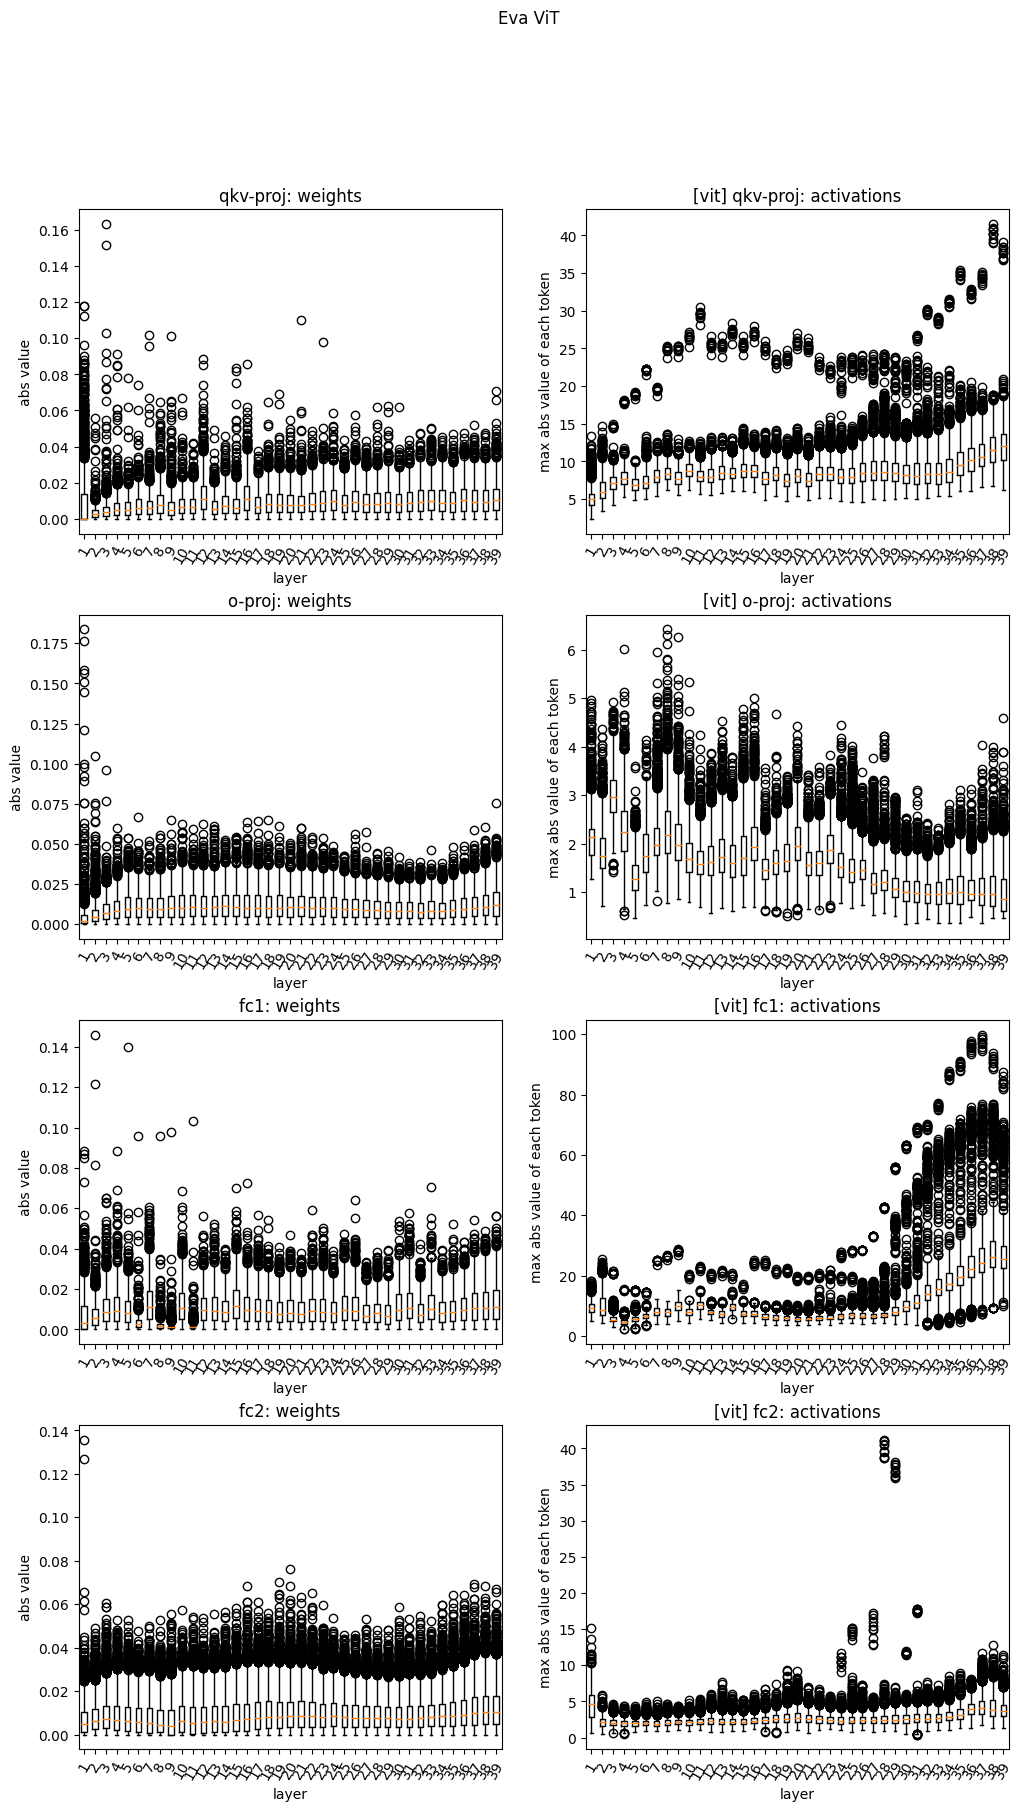

In [14]:
model = 'vit'
fig = plt.figure(figsize=(12, 20))
plt.subplots_adjust(hspace=0.25)
for i, component in enumerate(['qkv-proj.pt', 'o-proj.pt', 'fc1.pt', 'fc2.pt']):
    ax = plt.subplot(421 + i * 2)
    plot_weights(ax, model, component)
    ax = plt.subplot(421 + i * 2 + 1)
    plot_activations(ax, model, component)
plt.suptitle('Eva ViT')

Text(0.5, 0.98, 'Q-Former')

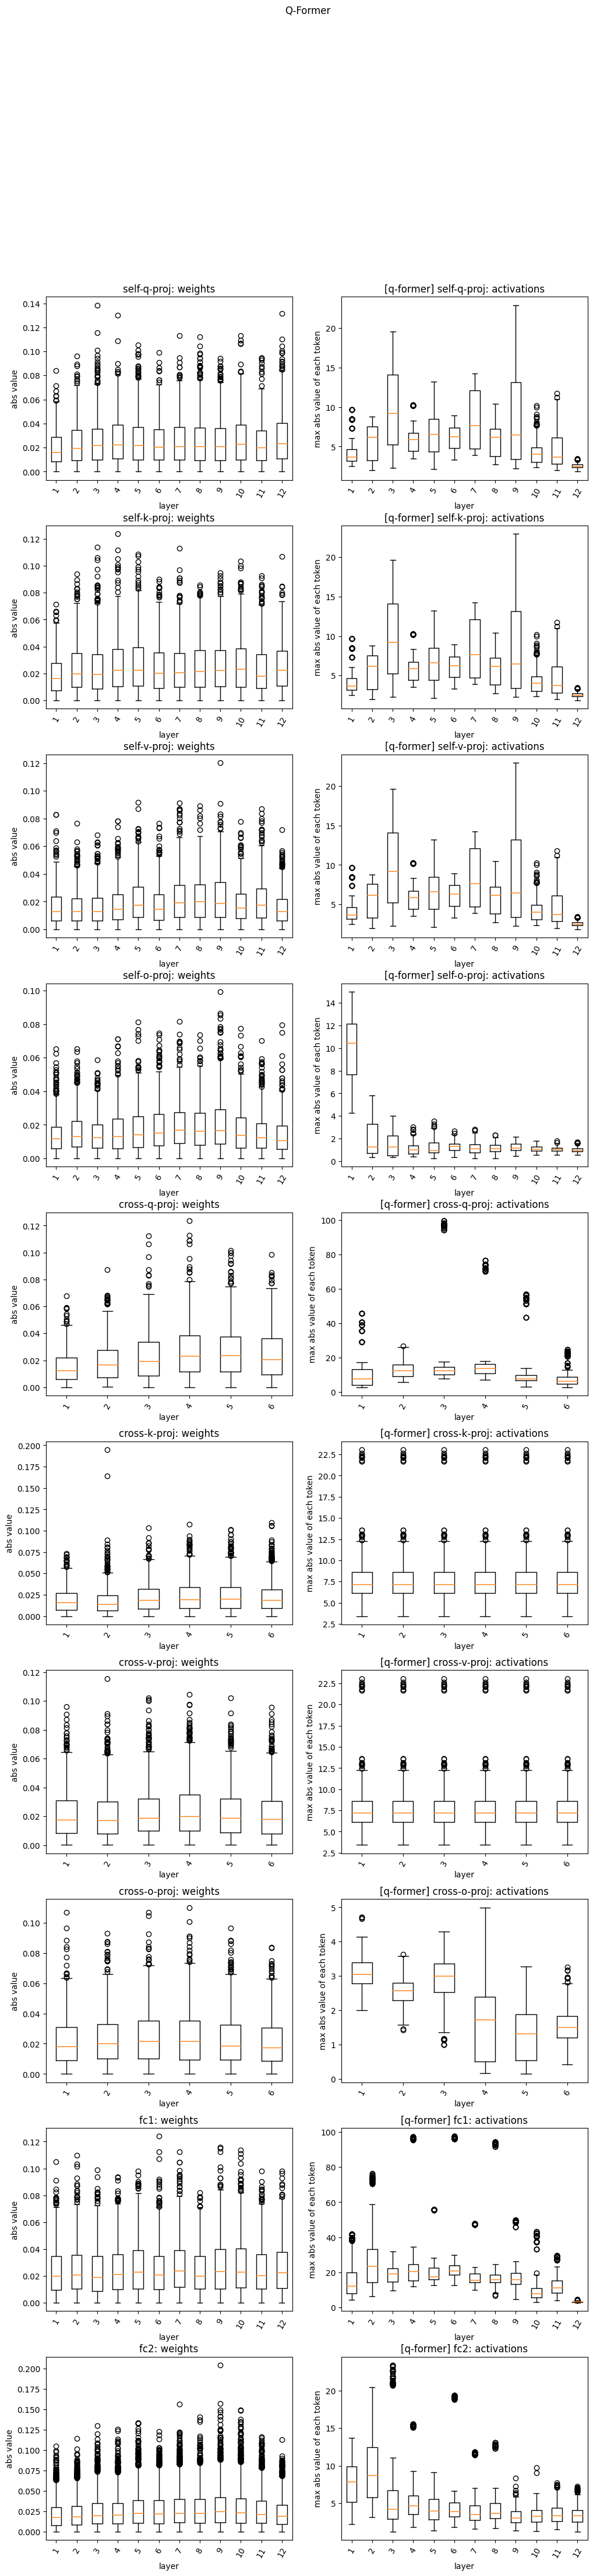

In [15]:
model = 'q-former'
fig = plt.figure(figsize=(12, 50))
plt.subplots_adjust(hspace=0.25)
for i, component in enumerate([
    'self-q-proj.pt',
    'self-k-proj.pt',
    'self-v-proj.pt',
    'self-o-proj.pt',
    'cross-q-proj.pt',
    'cross-k-proj.pt',
    'cross-v-proj.pt',
    'cross-o-proj.pt',
    'fc1.pt',
    'fc2.pt',
]):
    ax = plt.subplot2grid((10, 2), (i, 0))
    plot_weights(ax, model, component)
    ax = plt.subplot2grid((10, 2), (i, 1))
    plot_activations(ax, model, component)
plt.suptitle('Q-Former')

Text(0.5, 0.98, 'LLAMA')

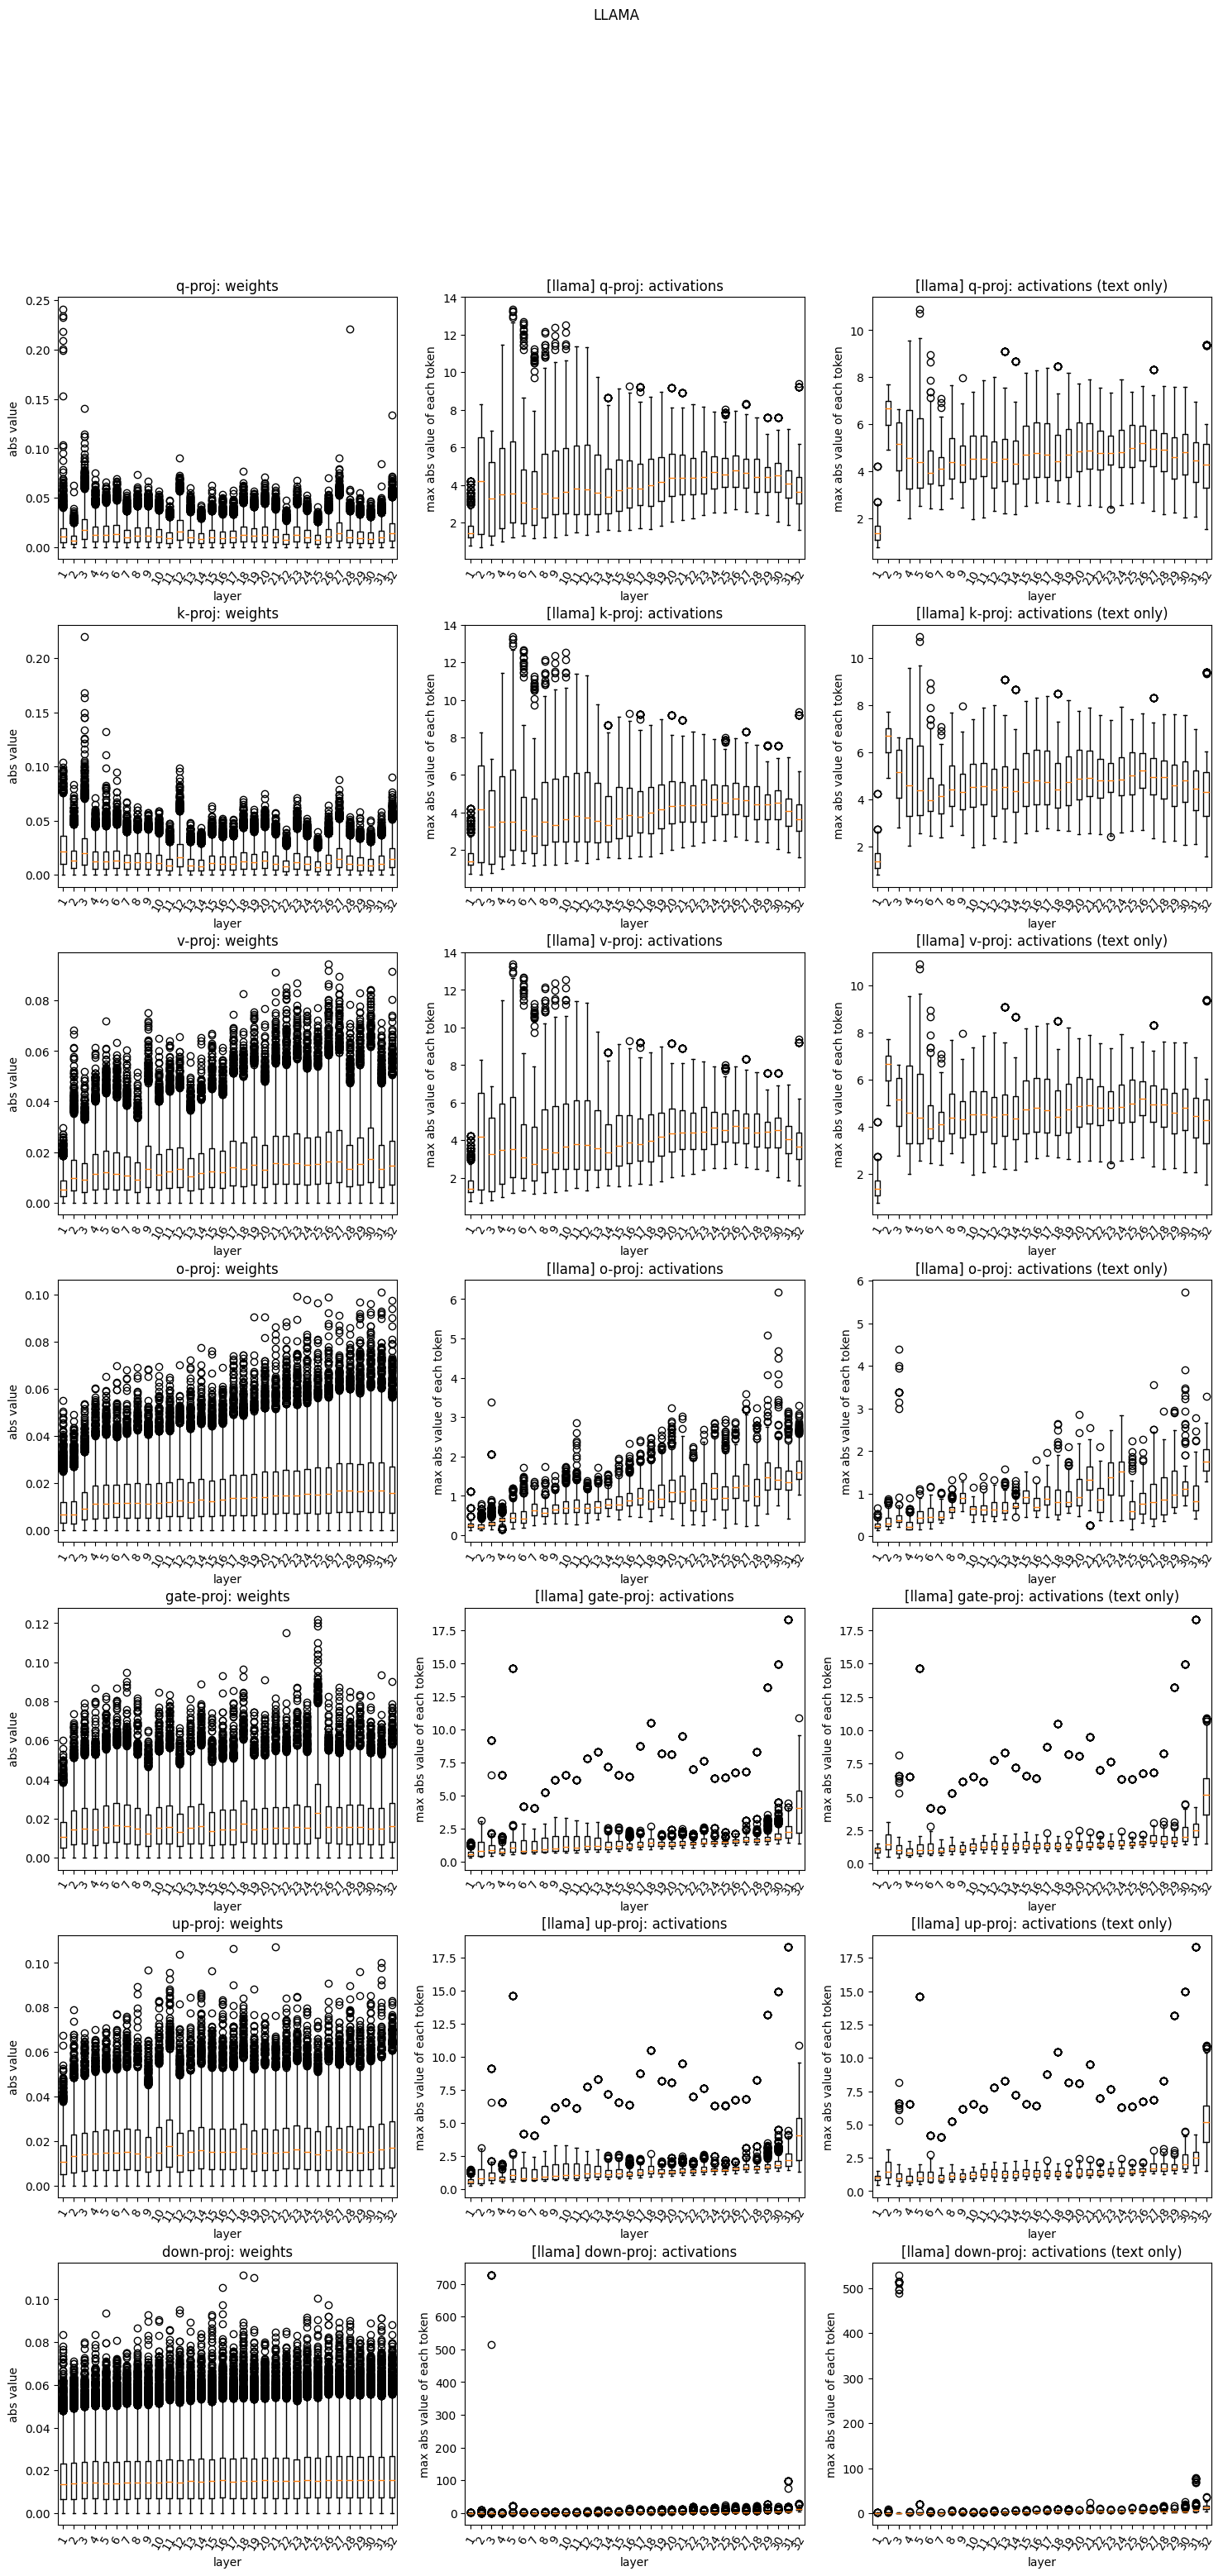

In [16]:
model = 'llama'
fig = plt.figure(figsize=(18, 35))
plt.subplots_adjust(hspace=0.25)
for i, component in enumerate([
    'q-proj.pt',
    'k-proj.pt',
    'v-proj.pt',
    'o-proj.pt',
    'gate-proj.pt',
    'up-proj.pt',
    'down-proj.pt',
]):
    ax = plt.subplot2grid((7, 3), (i, 0))
    plot_weights(ax, model, component)
    ax = plt.subplot2grid((7, 3), (i, 1))
    plot_activations(ax, model, component)
    ax = plt.subplot2grid((7, 3), (i, 2))
    plot_activations(ax, model, component, text_only=True)
plt.suptitle('LLAMA')

Text(0.5, 0.98, 'LLAMA Activations before Layer Norm')

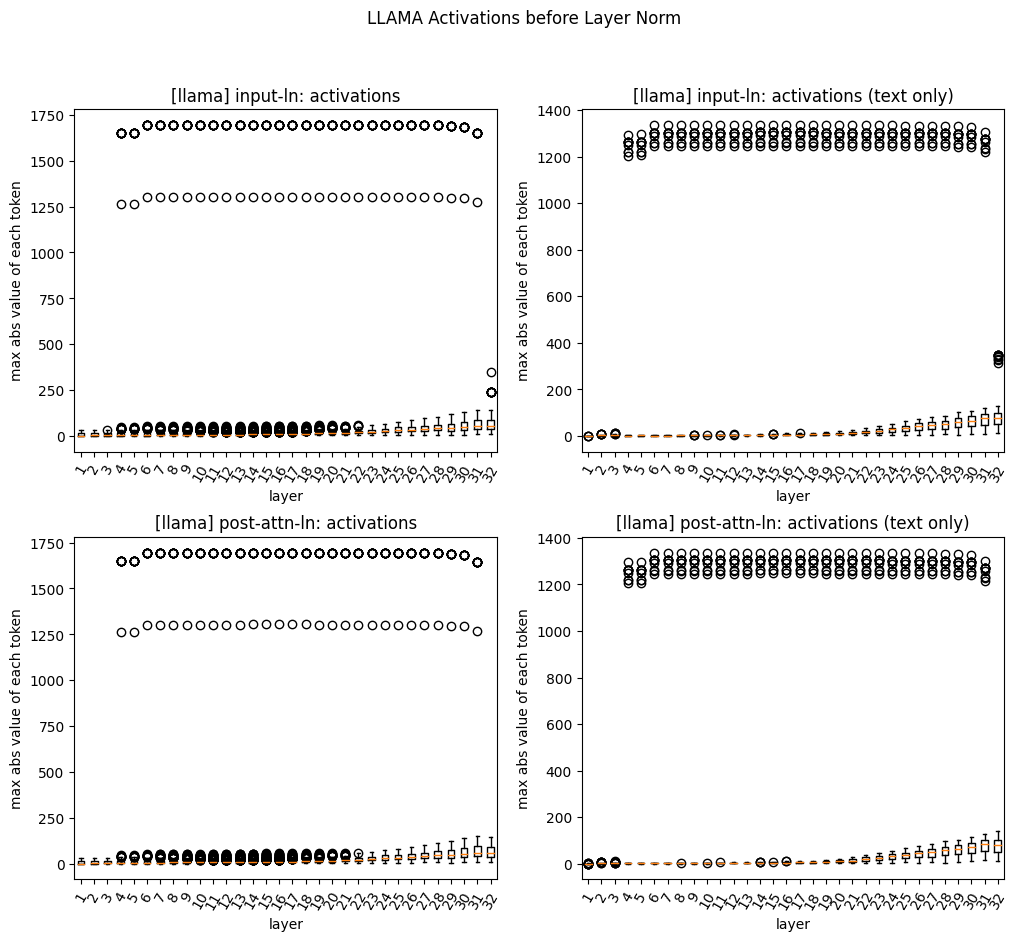

In [17]:
model = 'llama'
fig = plt.figure(figsize=(12, 10))
plt.subplots_adjust(hspace=0.25)
for i, component in enumerate([
    'input-ln.pt',
    'post-attn-ln.pt',
]):
    ax = plt.subplot2grid((2, 2), (i, 0))
    plot_activations(ax, model, component)
    ax = plt.subplot2grid((2, 2), (i, 1))
    plot_activations(ax, model, component, text_only=True)
plt.suptitle('LLAMA Activations before Layer Norm')

Text(0.5, 0.98, 'LLAMA vs. VICUNA Activations (text only)')

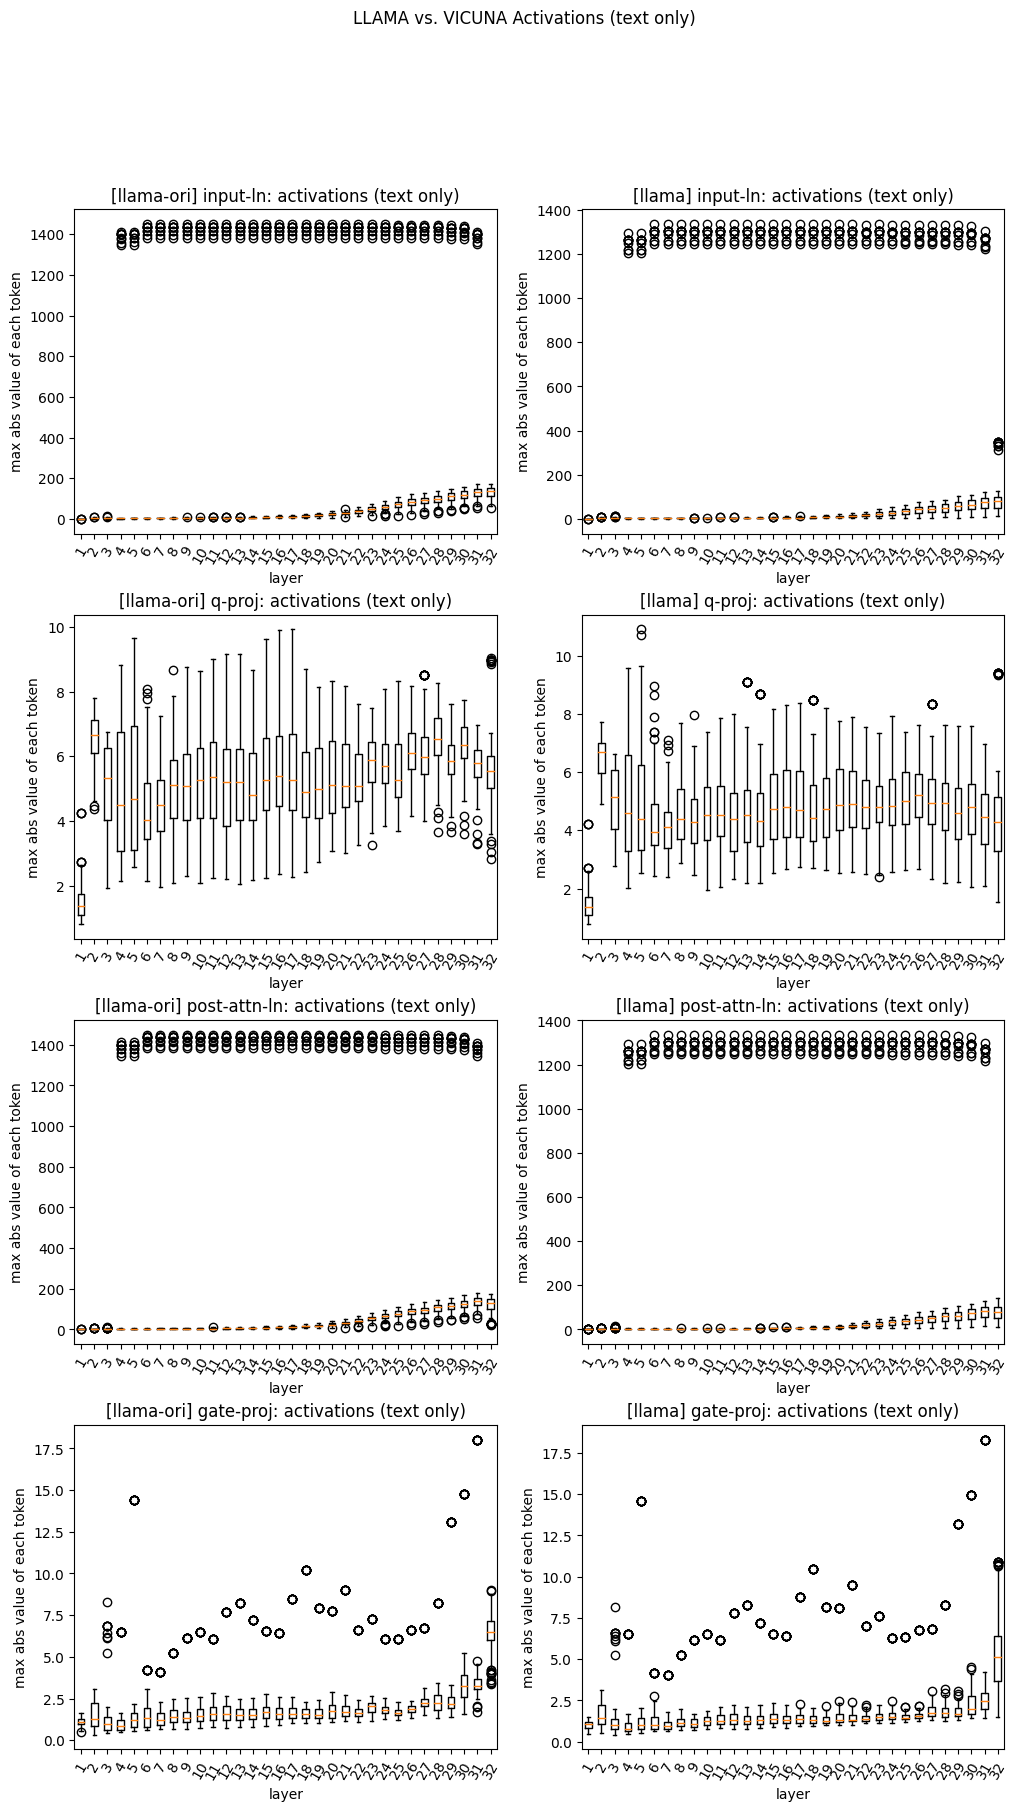

In [18]:
fig = plt.figure(figsize=(12, 20))
plt.subplots_adjust(hspace=0.25)
for i, component in enumerate([
    'input-ln.pt',
    'q-proj.pt',
    'post-attn-ln.pt',
    'gate-proj.pt',
]):
    ax = plt.subplot2grid((4, 2), (i, 0))
    plot_activations(ax, 'llama-ori', component, text_only=True)
    ax = plt.subplot2grid((4, 2), (i, 1))
    plot_activations(ax, 'llama', component, text_only=True)
plt.suptitle('LLAMA vs. VICUNA Activations (text only)')

Text(0.5, 0.98, 'LLAMA vs. VICUNA Activations')

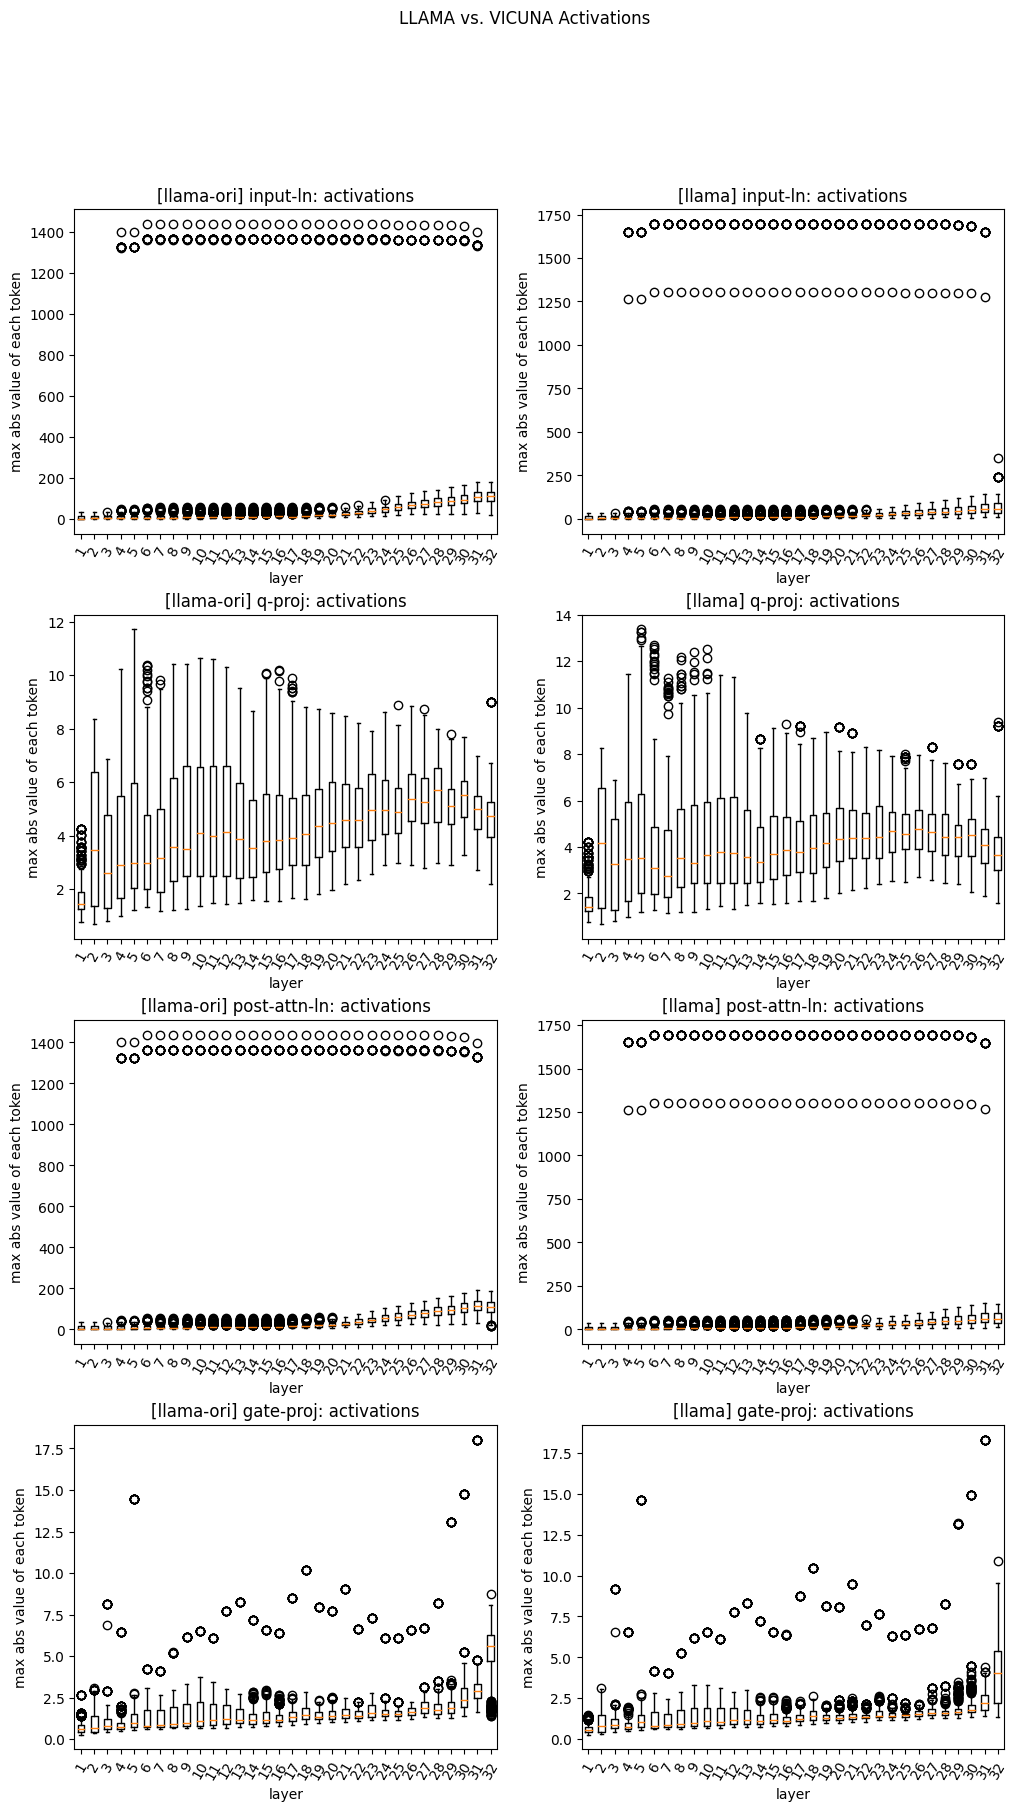

In [19]:
fig = plt.figure(figsize=(12, 20))
plt.subplots_adjust(hspace=0.25)
for i, component in enumerate([
    'input-ln.pt',
    'q-proj.pt',
    'post-attn-ln.pt',
    'gate-proj.pt',
]):
    ax = plt.subplot2grid((4, 2), (i, 0))
    plot_activations(ax, 'llama-ori', component, text_only=False)
    ax = plt.subplot2grid((4, 2), (i, 1))
    plot_activations(ax, 'llama', component, text_only=False)
plt.suptitle('LLAMA vs. VICUNA Activations')

In [6]:
def plot_tensor(field: str, model: str, component: str):
    tensor = torch.load(f'{SNAPSHOT_PATH}/{field}/{model}/{component}')
    tensor = tensor[0].detach().squeeze(0).abs()
    tensor = tensor.cpu().numpy()

    print(tensor.shape)
    plt.clf()
    fig = plt.figure(figsize=(12, 4))
    ax = plt.subplot(121)
    sns.heatmap(tensor, ax=ax)
    ax.set_xlabel('channel')
    ax.set_ylabel('tokens')

    _x, _y = np.arange(tensor.shape[1]), np.arange(tensor.shape[0])
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()
    ax = plt.subplot(122, projection='3d')
    colors = np.tile(tensor.max(axis=0).reshape((1, -1)), (tensor.shape[0], 1)).flatten()
    colors = plt.cm.jet(colors / tensor.max())
    tensor = tensor.flatten()
    ax.bar3d(x, y, 0, 1, 1, tensor, color=colors, shade=False)

    ax.set_xlabel('channel')
    ax.set_ylabel('tokens')
    # ax.set_zlabel('value')

    name = component[:-3]
    layer = name.split('-')[0]
    plt.suptitle(model + ' ' + field + f' #{name}')
    os.makedirs(f'{SNAPSHOT_PATH}/img/llama-layer-{layer}', exist_ok=True)
    plt.savefig(f'{SNAPSHOT_PATH}/img/llama-layer-{layer}/{name}.png')

(67, 4096)


(67, 4096)
(67, 4096)
(67, 4096)


<Figure size 640x480 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

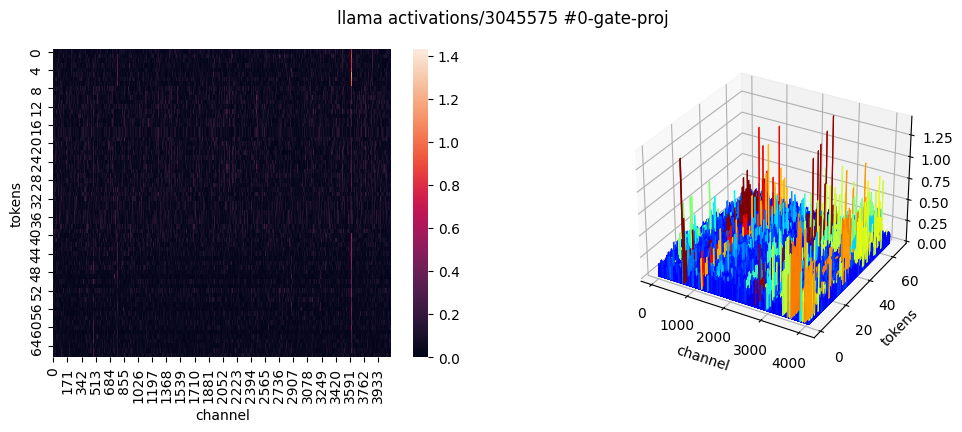

In [10]:
plot_tensor('activations/3045575', 'llama', '0-input-ln.pt')
plot_tensor('activations/3045575', 'llama', '0-q-proj.pt')
plot_tensor('activations/3045575', 'llama', '0-post-attn-ln.pt')
plot_tensor('activations/3045575', 'llama', '0-gate-proj.pt')

(67, 4096)
(67, 4096)
(67, 4096)
(67, 4096)


<Figure size 640x480 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

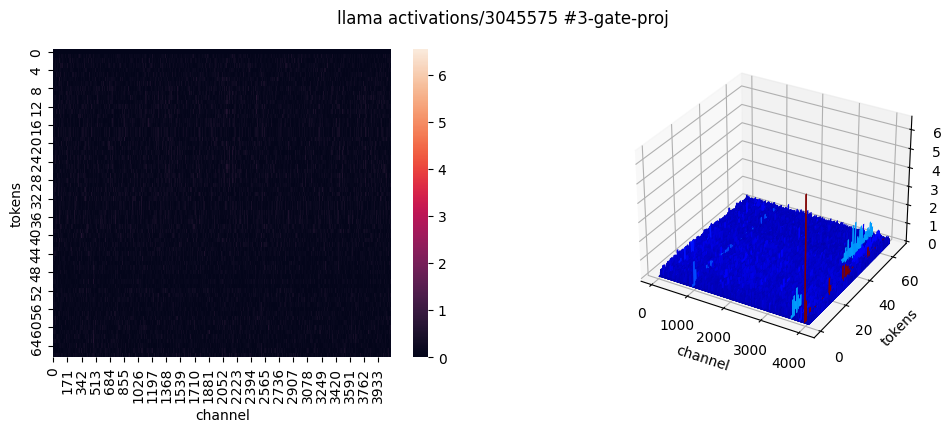

In [7]:
plot_tensor('activations/3045575', 'llama', '3-input-ln.pt')
plot_tensor('activations/3045575', 'llama', '3-q-proj.pt')
plot_tensor('activations/3045575', 'llama', '3-post-attn-ln.pt')
plot_tensor('activations/3045575', 'llama', '3-gate-proj.pt')

(67, 4096)
(67, 4096)
(67, 4096)
(67, 4096)


<Figure size 640x480 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

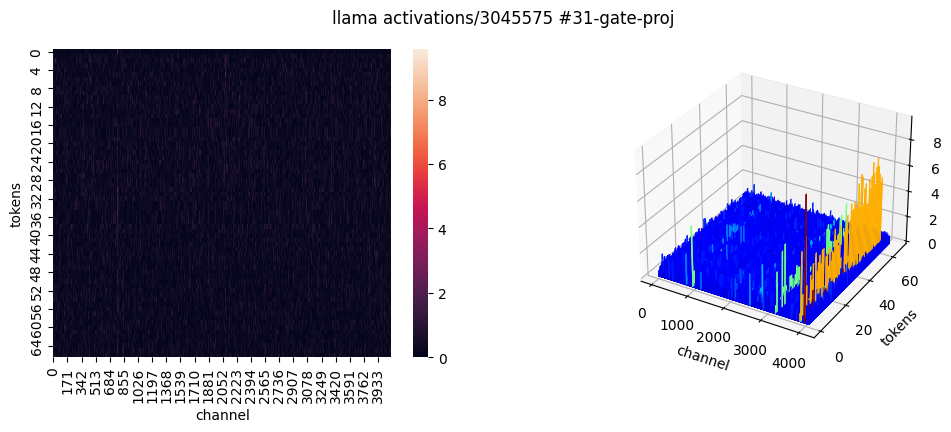

In [8]:
plot_tensor('activations/3045575', 'llama', '31-input-ln.pt')
plot_tensor('activations/3045575', 'llama', '31-q-proj.pt')
plot_tensor('activations/3045575', 'llama', '31-post-attn-ln.pt')
plot_tensor('activations/3045575', 'llama', '31-gate-proj.pt')